<h1> Testing PASTIS in imaging mode </h1>

Here we're testing the module "image_pastis.py" which is the version of PASTIS that still generates images. Since this is a module, it's a tiny bit harder to test, so I'm basically just going through the code step by step.

In [2]:
import os
import numpy as np
from astropy.io import fits
import poppy.zernike as zern
import poppy.matrixDFT as mft
import poppy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

os.chdir('../python/')
from config import CONFIG_INI
import util_pastis as util

# Change to output folder for this script
dir = '/Users/ilaginja/Documents/data_from_repos/pastis_data/calibration'
os.chdir(dir)

Since this is a module, its function will be called with input parameters, which I will define separetaly here to be able to use them.

In [3]:
# Define the aberration coeffitients "coef"
nb_seg = CONFIG_INI.getint('telescope', 'nb_subapertures')
zern_max = CONFIG_INI.getint('zernikes', 'max_zern')

nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration_nm')    # [nm] amplitude of aberration
zern_number = CONFIG_INI.getint('calibration', 'zernike')               # Which (Noll) Zernike we are calibrating for
wss_zern_nb = util.noll_to_wss(zern_number)                             # Convert from Noll to WSS framework


### What segmend are we aberrating? ###
i = 0   # segment 1 --> i=0, seg 2 --> i=1, etc.
### ------------------------------- ###

# Create arrays to hold Zernike aberration coefficients
Aber_WSS = np.zeros([nb_seg, zern_max])           # The Zernikes here will be filled in the WSS order!!!
                                                  # Because it goes into _apply_hexikes_to_seg().
Aber_Noll = np.copy(Aber_WSS)                     # This is the Noll version for later.

# Feed the aberration nm_aber into the array position
# that corresponds to the correct Zernike, but only on segment i
Aber_WSS[i, wss_zern_nb-1] = nm_aber / 1e9        # Aberration on the segment we're currenlty working on;
                                                  # convert to meters; -1 on the Zernike because Python starts
                                                  # numbering at 0.
Aber_Noll[i, zern_number-1] = nm_aber             # Noll version - in nm!

# Vector of aberration coefficients takes all segments, but only for the Zernike we currently work with
coef = Aber_Noll[:,zern_number-1]

# Define the (Noll) zernike number
zernike_pol = zern_number

# We're not calibrating
cali=False

print('coef:', coef)
print('Zernike (Noll):', util.zernike_name(zern_number, framework='Noll'))
print('Zernike (WSS):', util.zernike_name(wss_zern_nb, framework='WSS'))
print('Zernike number (Noll):', zernike_pol)

coef: [ 1000.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.]
Zernike (Noll): piston
Zernike (WSS): piston
Zernike number (Noll): 1


Now we'll start with the actual code in the module function.

Pupil shape: (1024, 1024)


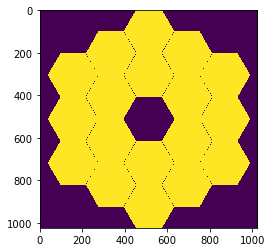

In [4]:
#-# Parameters
dataDir = CONFIG_INI.get('local', 'local_data_path')
nb_seg = CONFIG_INI.getint('telescope', 'nb_subapertures')
tel_size_m = CONFIG_INI.getfloat('telescope', 'diameter')
real_size_seg = CONFIG_INI.getfloat('telescope', 'flat_to_flat')   # size in meters of an individual segment flatl to flat
size_seg = CONFIG_INI.getint('numerical', 'size_seg')              # pixel size of an individual segment tip to tip
wvln = CONFIG_INI.getint('filter', 'lambda')
inner_wa = CONFIG_INI.getint('coronagraph', 'IWA')
outer_wa = CONFIG_INI.getint('coronagraph', 'OWA')
tel_size_px = CONFIG_INI.getint('numerical', 'tel_size_px')        # pupil diameter of telescope in pixels
im_size = CONFIG_INI.getint('numerical', 'im_size_px')             # image array size in px
sampling = CONFIG_INI.getfloat('numerical', 'sampling')            # sampling
largeur = tel_size_px * sampling                                   # size of pupil (?) with taking the sampling into account
size_px_tel = tel_size_m / tel_size_px                             # size of one pixel in pupil plane in m
px_sq_to_rad = size_px_tel * np.pi / tel_size_m
zern_max = CONFIG_INI.getint('zernikes', 'max_zern')
    
# Create Zernike mode object for easier handling
zern_mode = util.ZernikeMode(zernike_pol)

#-# Mean subtraction for piston
if zernike_pol == 1:
    coef -= np.mean(coef)

#-# Generic segment shapes
# Load pupil from file
pupil = fits.getdata(os.path.join(dataDir, 'segmentation', 'pupil.fits'))
pup_im = np.copy(pupil)

print('Pupil shape:', pupil.shape)

plt.imshow(pupil)
plt.show()

At this point, you have to make sure the pixel size  **size_seg** of your individual segment is correct, and this will be different depending on the pixel size of your total pupil.

With that, we create a mini segment.

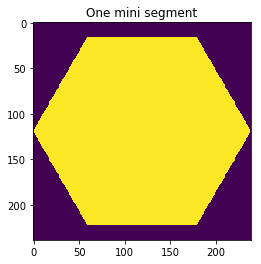

In [5]:
# Creat a mini-segment (one individual segment from the segmented aperture)
mini_seg_real = poppy.NgonAperture(name='mini', radius=real_size_seg)   # creating real mini segment shape with poppy
#test = mini_seg_real.sample(wavelength=wvln, grid_size=flat_diam, return_scale=True)   # fix its sampling with wavelength
mini_hdu = mini_seg_real.to_fits(wavelength=wvln, npix=size_seg)    # make it a fits file
mini_seg = mini_hdu[0].data 

plt.imshow(mini_seg)
plt.title('One mini segment')
plt.show()

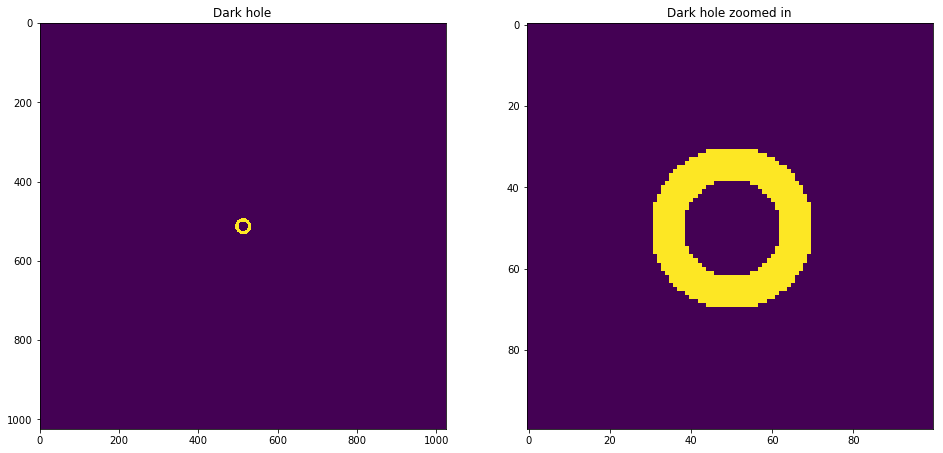

In [6]:
#-# Generate a dark hole
dh_area = util.create_dark_hole(pup_im, inner_wa, outer_wa, sampling)

xcen = int(pupil.shape[1]/2)
ycen = int(pupil.shape[0]/2)
boxsize = 50
    
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(dh_area)
plt.title('Dark hole')
plt.subplot(1, 2, 2)
plt.imshow(dh_area[ycen-boxsize:ycen+boxsize, xcen-boxsize:xcen+boxsize])
plt.title('Dark hole zoomed in')
plt.show()

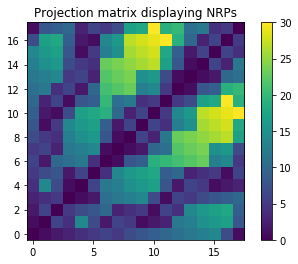

Non-redundant pairs (30):
[[ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 1 16]
 [ 2 15]
 [ 2 16]
 [ 2 17]
 [ 3 17]
 [ 7 11]
 [ 7 12]
 [ 7 13]
 [ 7 14]
 [ 7 15]
 [ 8 15]
 [ 9 15]
 [ 9 16]
 [ 9 17]
 [10 17]
 [11 17]
 [11 18]]


In [7]:
#-# Import information form previous script
Projection_Matrix = fits.getdata(os.path.join(dataDir, 'segmentation', 'Projection_Matrix.fits'))
vec_list = fits.getdata(os.path.join(dataDir, 'segmentation', 'vec_list.fits'))
NR_pairs_list = fits.getdata(os.path.join(dataDir, 'segmentation', 'NR_pairs_list_int.fits'))
NR_pairs_nb = NR_pairs_list.shape[0]
    
plt.imshow(Projection_Matrix[:,:,0], origin='lower')
plt.title('Projection matrix displaying NRPs')
plt.colorbar()
plt.show()
    
print('Non-redundant pairs (' + str(NR_pairs_nb) + '):')
print(NR_pairs_list)

We don't have calibration coefficients yet, so we skip the "if cali:" part.

Move on to the calculation of eq. 13 in the paper Leboulleux et al. 2018:

$$I(u) = ||\hat{Z_l}(u)||^2  \Bigg[ \sum_{k=1}^{n_{seg}} a^2_{k,l} + 2 \sum_{q=1}^{n_{NRP}} A_q cos(b_q \cdot u) \Bigg] $$

$A_q$... *generic coefficients*

$$A_q = \sum_{(i,j)} a_{i,l} a_{j,l}$$

In [8]:
ck = np.ones(nb_seg)
coef = coef * ck

#-# Generic coefficients
generic_coef = np.zeros(NR_pairs_nb)   # coefficients in front of the non redundant pairs, the A_q in eq. 13 in Leboulleux et al. 2018

for q in range(NR_pairs_nb):
    for i in range(nb_seg):
        for j in range(i+1, nb_seg):
            if Projection_Matrix[i, j, 0] == q+1:
                print('q:', q, 'i:', i, 'j:', j)
                generic_coef[q] += coef[i] * coef[j]
                print('ci:', coef[i], 'cj:', coef[j])
                    

q: 0 i: 0 j: 1
ci: 944.444444444 cj: -55.5555555556
q: 0 i: 0 j: 17
ci: 944.444444444 cj: -55.5555555556
q: 0 i: 1 j: 9
ci: -55.5555555556 cj: -55.5555555556
q: 0 i: 2 j: 10
ci: -55.5555555556 cj: -55.5555555556
q: 0 i: 3 j: 4
ci: -55.5555555556 cj: -55.5555555556
q: 0 i: 3 j: 11
ci: -55.5555555556 cj: -55.5555555556
q: 0 i: 4 j: 15
ci: -55.5555555556 cj: -55.5555555556
q: 0 i: 5 j: 16
ci: -55.5555555556 cj: -55.5555555556
q: 0 i: 6 j: 7
ci: -55.5555555556 cj: -55.5555555556
q: 0 i: 7 j: 8
ci: -55.5555555556 cj: -55.5555555556
q: 0 i: 12 j: 13
ci: -55.5555555556 cj: -55.5555555556
q: 0 i: 13 j: 14
ci: -55.5555555556 cj: -55.5555555556
q: 1 i: 0 j: 2
ci: 944.444444444 cj: -55.5555555556
q: 1 i: 1 j: 6
ci: -55.5555555556 cj: -55.5555555556
q: 1 i: 1 j: 10
ci: -55.5555555556 cj: -55.5555555556
q: 1 i: 3 j: 5
ci: -55.5555555556 cj: -55.5555555556
q: 1 i: 4 j: 12
ci: -55.5555555556 cj: -55.5555555556
q: 1 i: 4 j: 16
ci: -55.5555555556 cj: -55.5555555556
q: 1 i: 7 j: 9
ci: -55.5555555556 cj:

In [9]:
print('Generic coefficients:')
print(generic_coef)

Generic coefficients:
[-74074.07407407 -30864.19753086 -33950.61728395 -30864.19753086
 -74074.07407407 -18518.51851852 -86419.75308642 -33950.61728395
 -37037.03703704 -37037.03703704 -43209.87654321 -37037.03703704
 -37037.03703704 -33950.61728395  12345.67901235  18518.51851852
  18518.51851852  12345.67901235   9259.25925926   6172.83950617
   3086.41975309   6172.83950617   9259.25925926   6172.83950617
   3086.41975309   6172.83950617   9259.25925926   6172.83950617
   3086.41975309   6172.83950617]


$cos(b_q \cdot u)$... cos_u_mat

Sum over $a^2_{k,l}$... sum1

In [10]:
#-# Constant sum and cosine sum - calculating eq. 13 from Leboulleux et al. 2018
i_line = np.linspace(-im_size/2., im_size/2., im_size)
tab_i, tab_j = np.meshgrid(i_line, i_line)
cos_u_mat = np.zeros((int(im_size), int(im_size), NR_pairs_nb))
    
# Please explain what on Earth is happening here
# The -1 with each NR_pairs_list is because the segment names are saved starting from 1, but Python starts
# its indexing at zero, so we have to make it start at zero here too.
for q in range(NR_pairs_nb):
    cos_u_mat[:,:,q] = np.cos(px_sq_to_rad * (vec_list[NR_pairs_list[q,0]-1, NR_pairs_list[q,1]-1, 0] * tab_i) + 
                              px_sq_to_rad * (vec_list[NR_pairs_list[q,0]-1, NR_pairs_list[q,1]-1, 1] * tab_j))

sum1 = np.sum(coef**2)   # sum of all a_{k,l} in eq. 13 - this works only for single Zernikes (l fixed), because np.sum would sum over l too, which would be wrong.
    
print('cos:', cos_u_mat)
print('sum1:', sum1)

cos: [[[ 0.73952183 -0.27654882  0.44974419 ...,  0.73846523 -0.98240872
    0.93082808]
  [ 0.27977688  0.26537901  0.44974419 ...,  0.11535184  0.4228151
    0.2941121 ]
  [-0.26213732  0.72936618  0.44974419 ..., -0.87333625  0.48804727
   -0.97525414]
  ..., 
  [-0.28300178  0.74402948  0.44974419 ..., -0.82785082  0.41059521
   -0.98756432]
  [-0.74177984  0.98331724  0.44974419 ...,  0.93907413 -0.97980968
   -0.08217993]
  [-0.98270038  0.93380899  0.44974419 ..., -0.27012805  0.73501224
    0.99997772]]

 [[ 0.9124403  -0.94273823  0.98673234 ...,  0.19582045 -0.11529838
   -0.37794088]
  [ 0.56498113 -0.63030735  0.98673234 ...,  0.68113121 -0.73850152
    0.95172969]
  [ 0.05158946 -0.13275793  0.98673234 ..., -0.99220878  0.97876489
    0.23418071]
  ..., 
  [ 0.02992182 -0.11123427  0.98673234 ..., -0.99927175  0.99284389
    0.17048073]
  [-0.49590069  0.42352505  0.98673234 ...,  0.5532238  -0.48353663
   -0.99542236]
  [-0.87607931  0.8338969   0.98673234 ...,  0.3524345

$\Bigg[ \sum_{k=1}^{n_{seg}} a^2_{k,l} + 2 \sum_{q=1}^{n_{NRP}} A_q cos(b_q \cdot u) \Bigg]$ = sum2 + generic_coef[q] * cos_u_mat[:,:,q]

In [11]:
sum2 = np.zeros((int(im_size), int(im_size)))
for q in range(NR_pairs_nb):
    sum2 = sum2 + generic_coef[q] * cos_u_mat[:,:,q]
    
print('sum2:', sum2)

sum2: [[  70151.95855823   35231.98961063   11317.96404375 ...,   11317.96404375
    35231.98961063   70151.95855822]
 [  86521.59447172  -34487.48261343  -92911.43888944 ...,  -92911.43888945
   -34487.48261346   86521.5944717 ]
 [ -33865.08953749  -99072.10081569 -125852.71666363 ..., -125852.71666367
   -99072.10081573  -33865.08953751]
 ..., 
 [ -33865.08953751  -99072.10081573 -125852.71666367 ..., -125852.71666363
   -99072.10081569  -33865.08953749]
 [  86521.5944717   -34487.48261346  -92911.43888945 ...,  -92911.43888944
   -34487.48261343   86521.59447172]
 [  70151.95855822   35231.98961063   11317.96404375 ...,   11317.96404375
    35231.98961063   70151.95855823]]


/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((239, 239), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


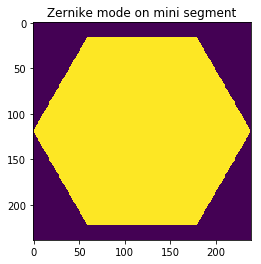

In [12]:
#-# Local Zernike
# Generate a basis of Zernikes with the mini segment being the support
isolated_zerns = zern.hexike_basis(nterms=zern_max, npix=size_seg, rho=None, theta=None, vertical=False, outside=0.0)

# Calculate the Zernike that is currently being used and put it on one single subaperture, the result is Zer
# Apply the currently used Zernike to the mini-segment.
if zernike_pol == 1:
    Zer = mini_seg
elif zernike_pol in range(2, zern_max-2):
    Zer = mini_seg * isolated_zerns[zernike_pol-1]
    
plt.imshow(Zer)
plt.title('Zernike mode on mini segment')
plt.show()

Simply to show what it would look like for other Zernikes:

In [13]:
zern_iter = np.arange(8) + 1   # +1 so that they start at 1
print('Zernike numbers (Noll):', zern_iter)

minizern_stack = []
for i in range(zern_iter.shape[0]):
    if i+1 == 1:
        minizern_stack.append(mini_seg)
    elif i+1 in range(2, zern_max-2):
        minizern_stack.append(mini_seg * isolated_zerns[i])
        
minizern_stack = np.array(minizern_stack)

Zernike numbers (Noll): [1 2 3 4 5 6 7 8]


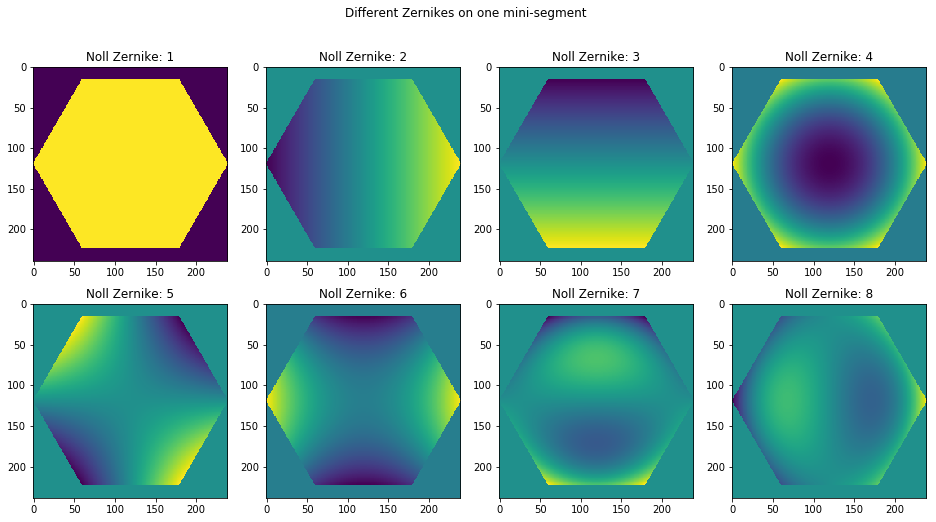

In [14]:
plt.figure(figsize=(16, 8))
plt.suptitle('Different Zernikes on one mini-segment')
for i in range(minizern_stack.shape[0]):
    plt.subplot(2, 4, i+1)
    plt.imshow(minizern_stack[i])
    plt.title('Noll Zernike: ' + str(i+1))
plt.show()

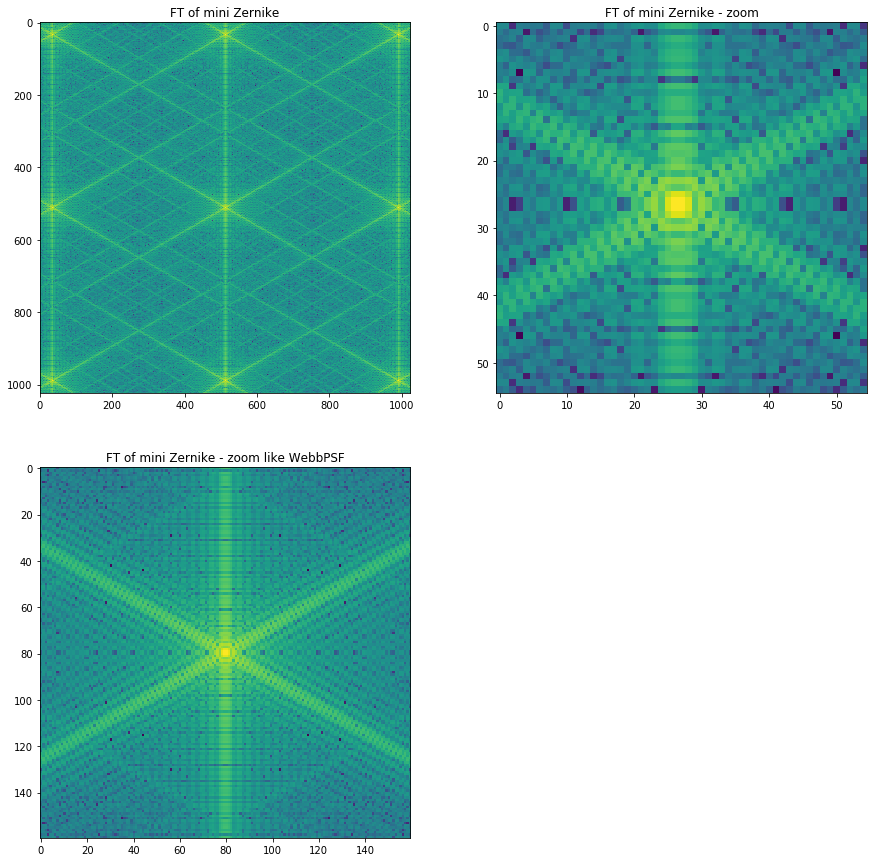

In [17]:
# Fourier Transform of the Zernike - the global envelope
mf = mft.MatrixFourierTransform()
ft_zern = mf.perform(Zer, im_size/sampling, im_size)

xcen = int(ft_zern.shape[1]/2.)
ycen = int(ft_zern.shape[0]/2.)
boxw = int(161/2)    # We can see in the 3. notebook that WebbPSF produces 161 x 161 px images by default.

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(np.abs(ft_zern), norm=LogNorm())
plt.title('FT of mini Zernike')
plt.subplot(2, 2, 2)
plt.imshow(np.abs(ft_zern)[485:540, 485:540], norm=LogNorm())
plt.title('FT of mini Zernike - zoom')
plt.subplot(2, 2, 3)
plt.imshow(np.abs(ft_zern)[ycen-boxw:ycen+boxw, xcen-boxw:xcen+boxw], norm=LogNorm())
plt.title('FT of mini Zernike - zoom like WebbPSF')
plt.show()

Also check the global envelopes from the other Zernikes on the mini-segment.

In [18]:
mini_ft = []
for i in range(minizern_stack.shape[0]):
    ft_klein = mf.perform(minizern_stack[i], im_size/sampling, im_size)
    mini_ft.append(ft_klein)
    
mini_ft = np.array(mini_ft)

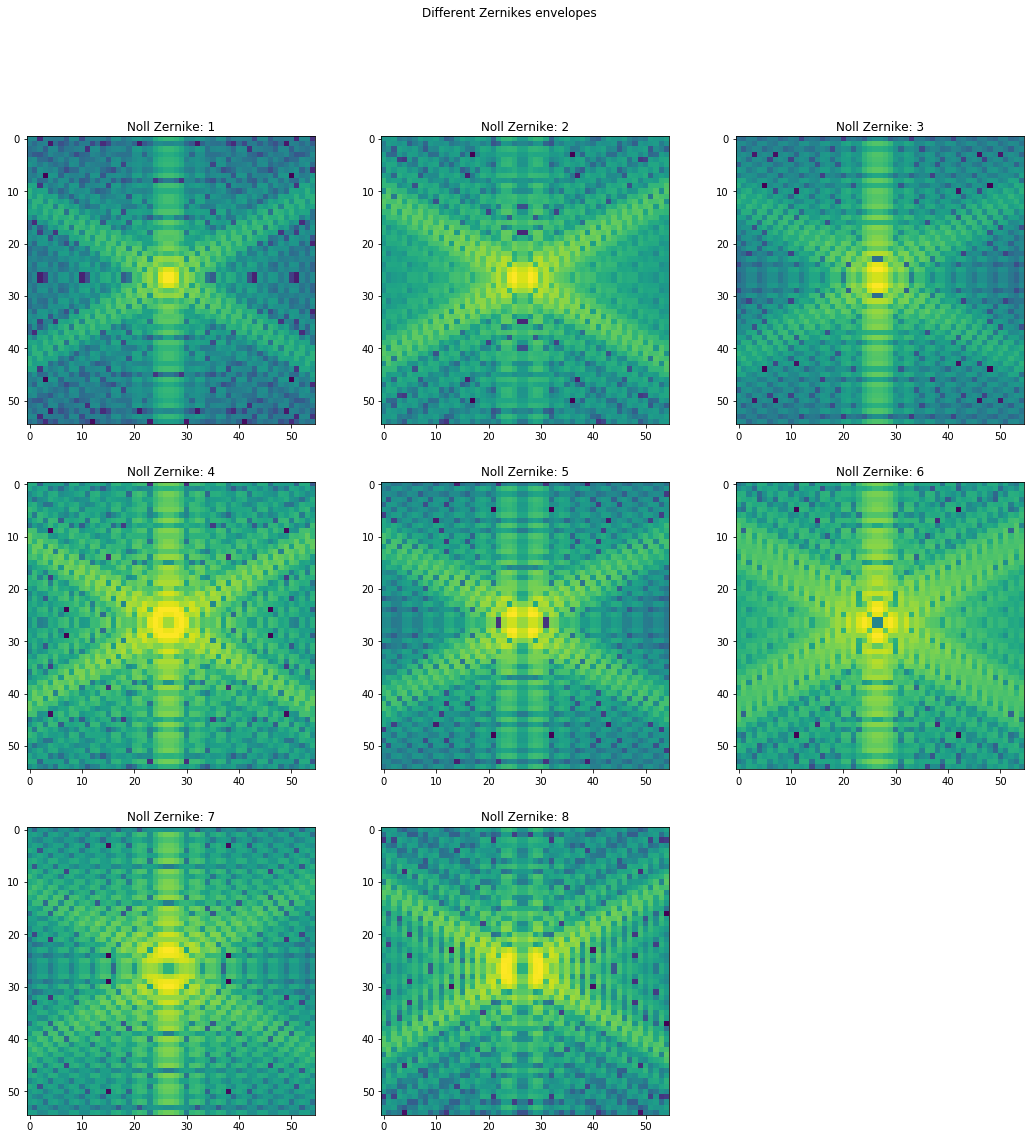

In [19]:
plt.figure(figsize=(18, 18))
plt.suptitle('Different Zernikes envelopes')
for i in range(mini_ft.shape[0]):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.abs(mini_ft[i])[485:540, 485:540], norm=LogNorm())
    plt.title('Noll Zernike: ' + str(i+1))
plt.show()

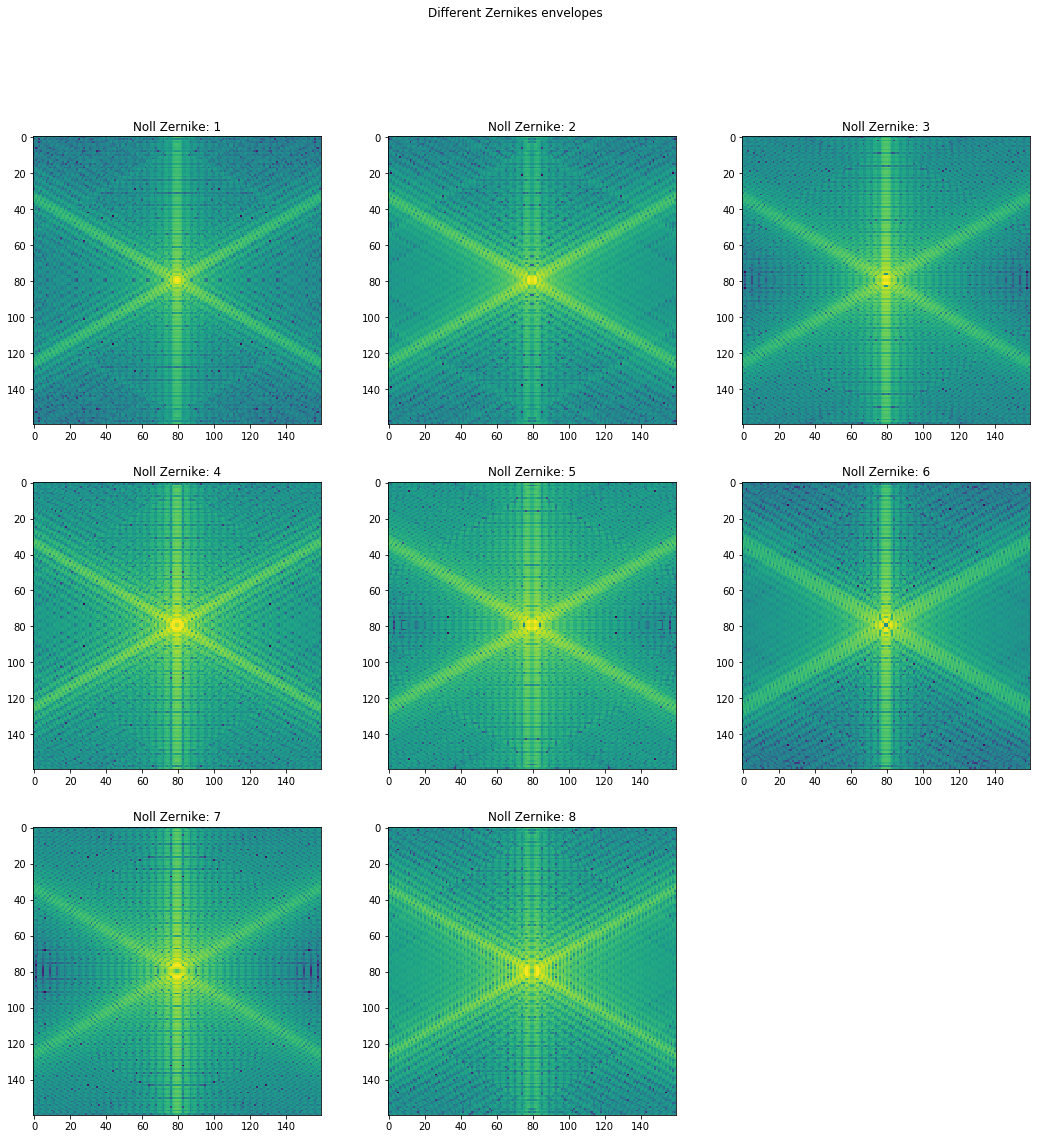

In [20]:
# Now in the image size of the WebbPSF images from 3. notebook
plt.figure(figsize=(18, 18))
plt.suptitle('Different Zernikes envelopes')
for i in range(mini_ft.shape[0]):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.abs(mini_ft[i])[ycen-boxw:ycen+boxw, xcen-boxw:xcen+boxw], norm=LogNorm())
    plt.title('Noll Zernike: ' + str(i+1))
plt.show()

They correspond to what Lucie has in her paper, which is pretty cool. The sampling is very different though, as I tried to match the sampling to the WebbPSF default.

Moving on. Calculating the full $I(u)$ now.

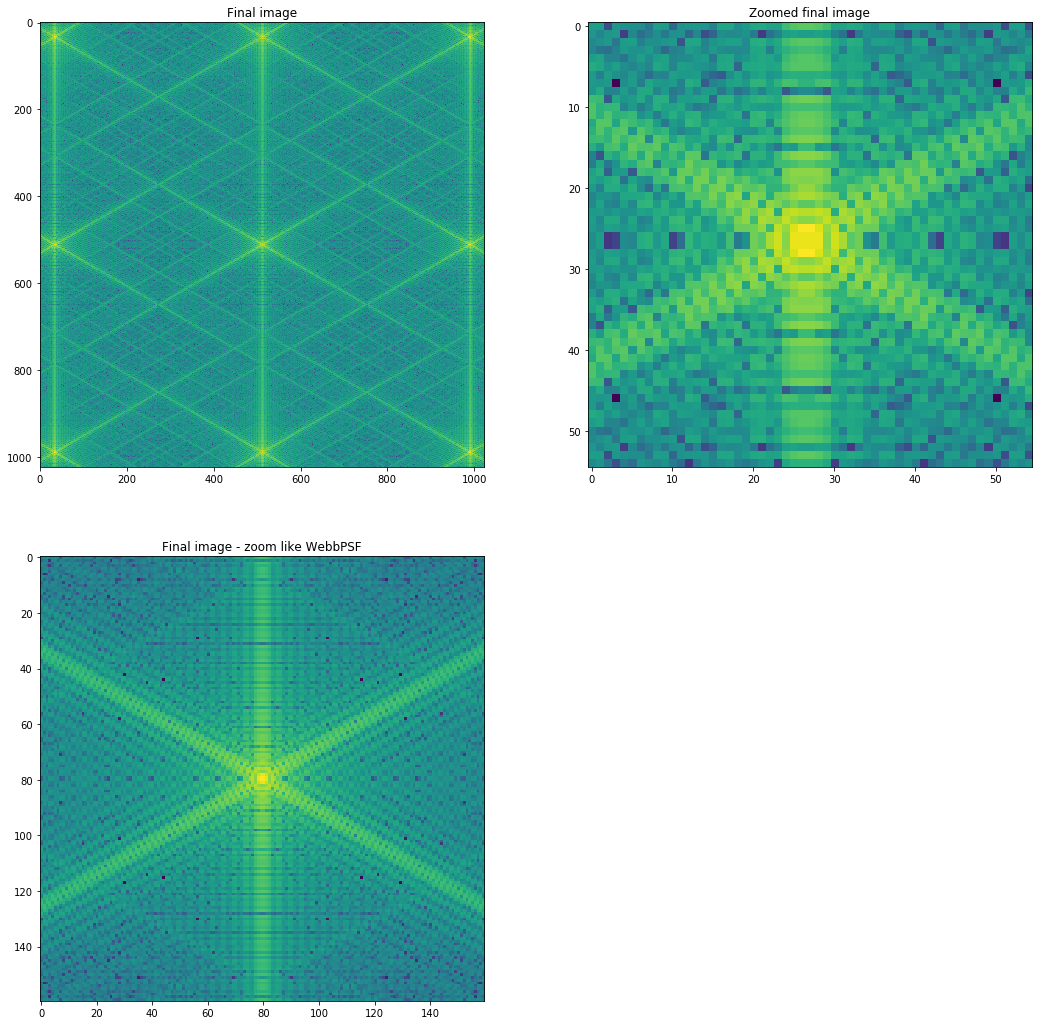

In [24]:
#-# Final image
# Generating the final image that will get passed on to the outer scope, I(u) in eq. 13
intensity = np.abs(ft_zern**2 * (sum1 + 2. * sum2))

plt.figure(figsize=(18,18))
plt.subplot(2, 2, 1)
plt.imshow(intensity, norm=LogNorm())
plt.title('Final image')
plt.subplot(2, 2, 2)
plt.imshow(intensity[485:540, 485:540], norm=LogNorm())   #[450:575, 450:575]
plt.title('Zoomed final image')
plt.subplot(2, 2, 3)
plt.imshow(np.abs(ft_zern)[ycen-boxw:ycen+boxw, xcen-boxw:xcen+boxw], norm=LogNorm())
plt.title('Final image - zoom like WebbPSF')
plt.show()

There's some weird stuff going on in this image and I have no clue where it is coming from. See those weird dark dots appearing in a regular grid all over the PSF? Those come from the cosine terms, becuase the dots change when I change the cosines. First they were lines across the PSF, but they change as I change the conversion factor fro "square pixels" to radians. I'll need to figure out where this is coming from.

Update: Oooh the weird stuff is gone now! I realized that I was telling the FT that the image siz eis supposed to be 2048 instead of the actual 1024. Is this now fully fixed??

/Users/ilaginja/Documents/Git/PASTIS/python/util_pastis.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return(im[y-bb:y+bb, x-bb:x+bb])
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


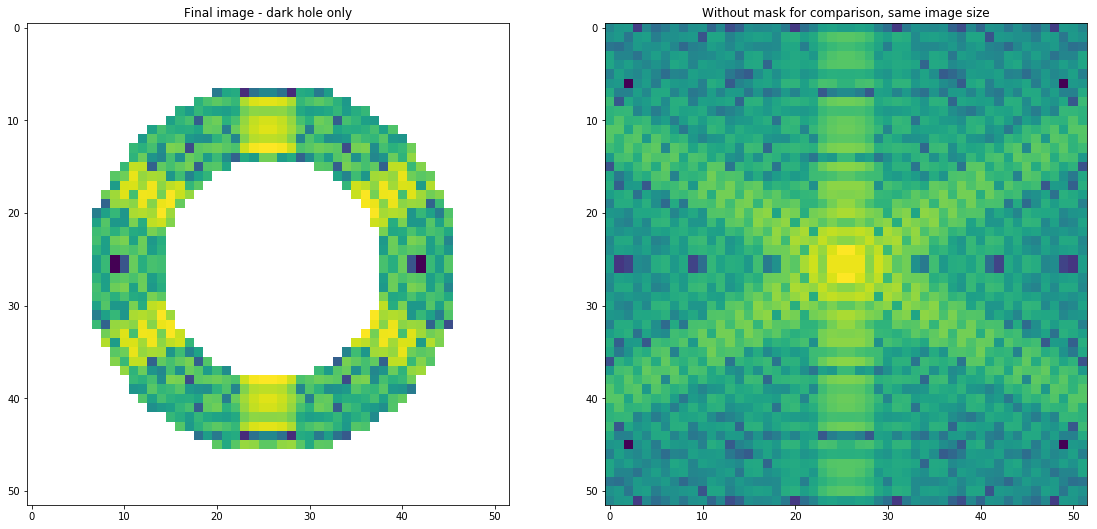

In [25]:
# PASTIS is only valid inside the dark hole.
intensity_zoom = util.zoom(intensity, int(intensity.shape[0]/2.), int(intensity.shape[1]/2.), sampling*(outer_wa+3))       # zoom box must be big enough to capture entire DH
dh_area_zoom = util.zoom(dh_area, int(dh_area.shape[0]/2.), int(dh_area.shape[1]/2.), sampling*(outer_wa+3))

dh_psf = dh_area_zoom * intensity_zoom

up = im_size/2 + sampling*(outer_wa+3)
down = im_size/2 - sampling*(outer_wa+3)
    
plt.figure(figsize=(19,10))
plt.subplot(1, 2, 1)
plt.imshow(dh_psf, norm=LogNorm())
plt.title('Final image - dark hole only')
plt.subplot(1, 2, 2)
plt.imshow(intensity[down:up, down:up], norm=LogNorm())
plt.title('Without mask for comparison, same image size')
plt.show()

Crop out the DH for the Zernike envelopes.

/Users/ilaginja/Documents/Git/PASTIS/python/util_pastis.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return(im[y-bb:y+bb, x-bb:x+bb])


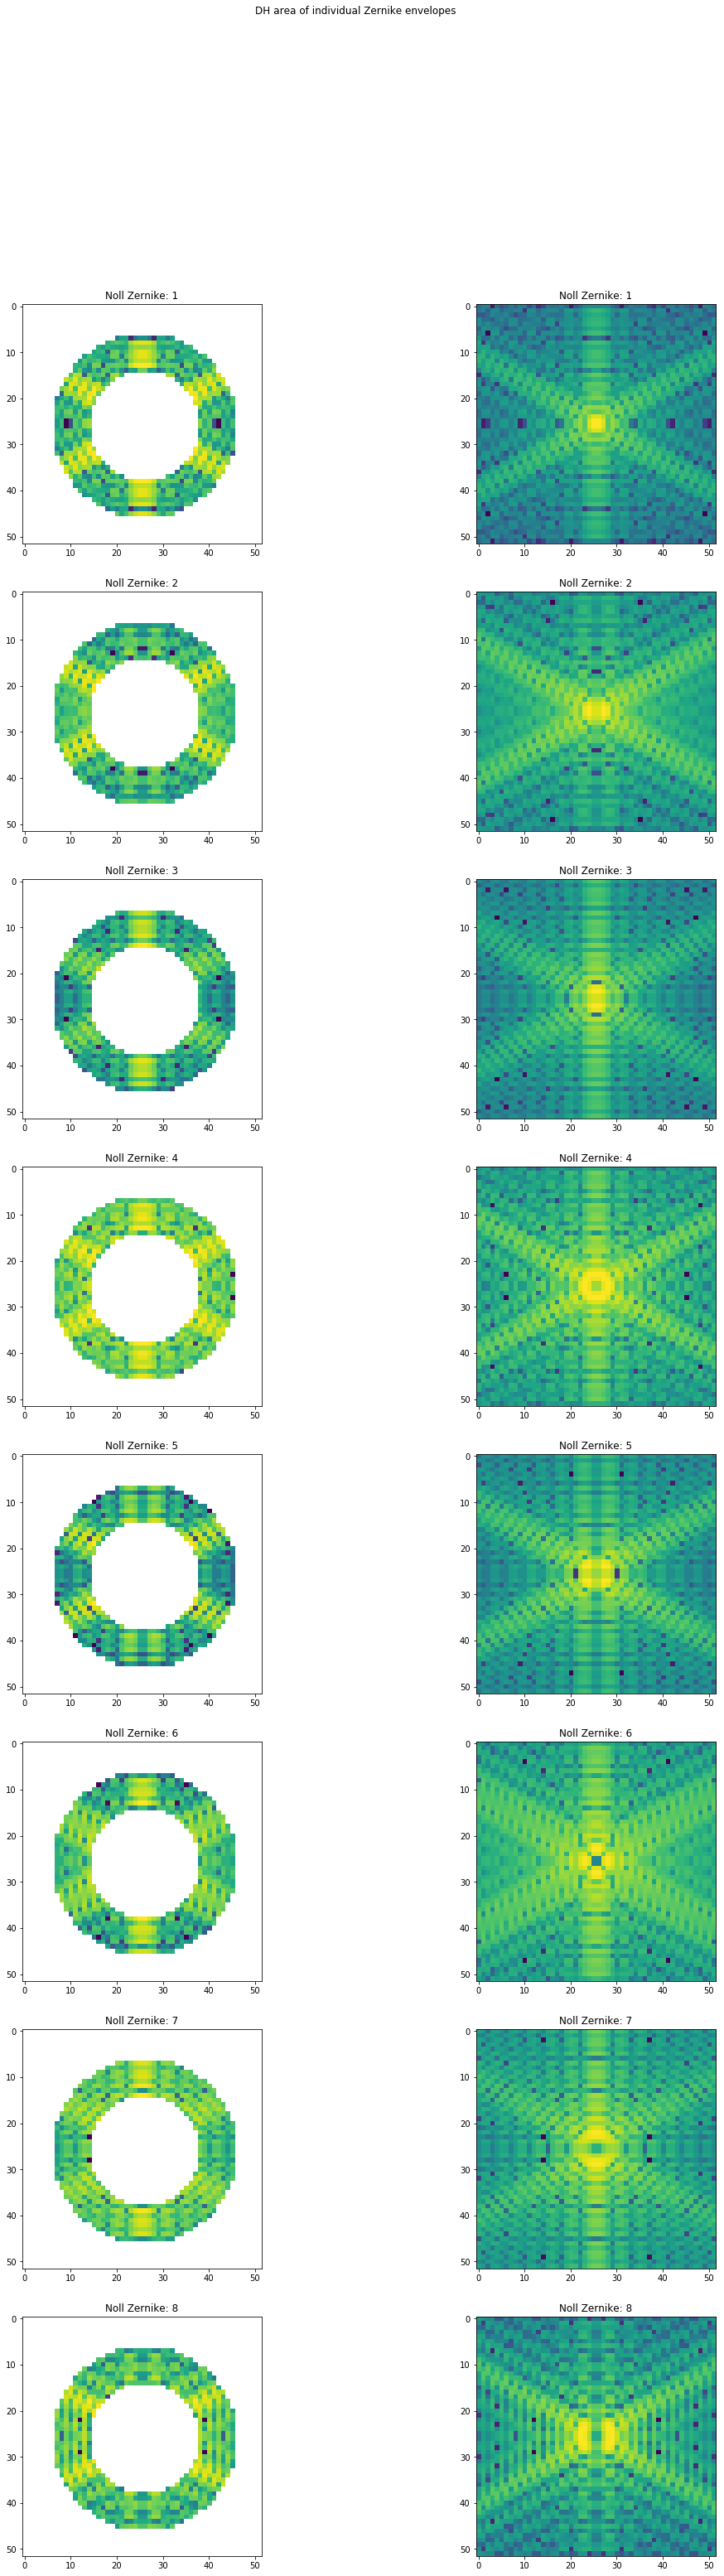

In [40]:
mini_im = np.abs(mini_ft)    # don't forget that mini_ft is the E-field
mini_dh_stack = []
plt.figure(figsize=(18, 50))
plt.suptitle('DH area of individual Zernike envelopes')
for i in range(mini_ft.shape[0]):
    mini_zoom = util.zoom(mini_im[i], int(mini_im[i].shape[0]/2.), int(mini_im[i].shape[1]/2.), sampling*(outer_wa+3))
    mini_dh = dh_area_zoom * mini_zoom
    mini_dh_stack.append(mini_dh)
    
    plt.subplot(8, 2, i*2+1)
    plt.imshow(np.abs(mini_dh), norm=LogNorm())
    plt.title('Noll Zernike: ' + str(i+1))
    
    plt.subplot(8, 2, i*2+2)
    plt.imshow(np.abs(mini_zoom), norm=LogNorm())
    plt.title('Noll Zernike: ' + str(i+1))
    
plt.show()